# Graph Coloring Problem With Different Optimization Algorithms

---

## 📚 Data Source Reference

The benchmark instances used in this experiment were obtained from the:

**Graph Coloring Instances collection by Cnam**
* **URL:** [https://cedric.cnam.fr/~porumbed/graphs/](https://cedric.cnam.fr/~porumbed/graphs/)


### Benchmark Instances and Best Known Solutions (BKS)

The following 3 instances were selected for the experiment, along with their known BKS (Best $k$):

| Graph Instance | Vertices | Edges | Best Known $k$ ($\chi(G)$) |
| :--- | :--- | :--- | :--- |
| `dsjc250.5.col` | 250 | 31,336 | 28/? |
| `dsjc500.9.col` | 500 | 224,874 | 126/? |
| `dsjc1000.5.col` | 1000 | 249,826 | 85/? |

*Note: The `?` in the original source often means the chromatic number is not *proven* optimal, but it is the best-known result.*
---

#### Import Section

In [1]:
import matplotlib.colors as mcolors
import networkx as nx
import matplotlib.pyplot as plt
from random import choice
import numpy as np
from numpy.random import choice
import sys
from collections import defaultdict
from collections	import defaultdict, deque
from copy 			import deepcopy
from os				import system
from random         import randrange
import random
import os
import tqdm
import pandas as pd
import math
from itertools import chain
import operator
import time

#### Global Variables

In [2]:
# Generation random.seed for every algorithm.
seed = 1773

# Generation max iteration for every algorithm
max_iterations = 7000

#Time Table 
df_time_table = pd.DataFrame(columns=['fileName','algorithm','elapsedTime'])

#### Reading data files

In [3]:
# Reading file_names for every algorithm.
fileNames = []
for root, dirs, files in os.walk("./data/", topdown=False):
    for name in files:
        fileNames.append(name)
            
# print(*fileNames, sep='\n' )

#### Global methods

In [4]:
# Generating matrix from given file
def generateMatrixFromFile (file_name):
    """
    Read the graph from the input file and create the adjacency matrix
    """
    global numNodes
    global numEdges
    lines = open('data/' + file_name).readlines()

    # get the number of nodes and total links
    tokens = lines[0].split()
    numNodes = int(tokens[0])
    numEdges = int(tokens[1])

    # create matrix for connections in graph
    matrix = np.zeros((numNodes, numNodes))
    for line in lines[1 : numEdges+1]:
        tokens = line.split()
        node = int(tokens[0])
        link_to_node = int(tokens[1])
        
        # Replaces '0' with '1' wherever there is an edge
        matrix[node][link_to_node] = 1
        matrix[link_to_node][node] = 1

    return matrix

<i>Difference between adjacency list and adjacency matrix: https://www.geeksforgeeks.org/comparison-between-adjacency-list-and-adjacency-matrix-representation-of-graph/</i>

In [5]:
#Generate adjacency list from adjacency matrix 
def adjacenecy_matrix_to_adjacency_list(matrix):
	adjacency_list = defaultdict(list)
	for row in range(0, len(matrix)):
		for element in range(0, len(matrix[row])):
			if matrix[row][element] == 1:
				adjacency_list[row].append(element)
	return dict(adjacency_list)

In [6]:
def plot_colored_graph(coloring,total_color,adjacency_list, accuracy):
    G = nx.Graph()
    for node, edges in adjacency_list.items():
        G.add_node(node)
        for edge in edges:
            G.add_edge(node, edge)

    colors = [coloring[node] for node in G.nodes()]
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color=colors)
    plt.title('The total color number used in this graph: ' + str(total_color) + " with accuracy: %" + str(round(accuracy, 2)))
    # Show the graph
    plt.show()

In [7]:
#Checks accuracy of a given colored graph and its adjacency list.
def check_accuracy(coloring, graph):
    accuracy = 0
    for node, color in coloring.items():
        for neighbor in graph[node]:
            if coloring[neighbor] == color:
                accuracy += 1
    total_edges = sum([len(graph[node]) for node in graph])
    return (total_edges - accuracy) / total_edges * 100


In [8]:
def append_row(df, row):
    return pd.concat([
                df, 
                pd.DataFrame([row], columns=row.index)]
           ).reset_index(drop=True)

In [9]:
def plot_difference(df):
    # Group the dataframe by fileName and algorithm
    grouped = df.groupby(['fileName','algorithm'])['minimumColor'].min()
    # Plot the grouped dataframe
    grouped.unstack().plot(kind='bar', stacked=False)
    # Show the plot
    plt.show()

In [10]:
def plot_time_table(df):
    # Group the dataframe by fileName and algorithm
    grouped = df.groupby(['fileName','algorithm'])['elapsedTime'].min()
    # Plot the grouped dataframe
    grouped.unstack().plot(kind='bar', stacked=False)
    # Show the plot
    plt.show()

In [11]:
def plot_results():
    results = pd.DataFrame(columns=['fileName','algorithm','minimumColor'])
    
    for fileName in fileNames:
        new_row = pd.Series({'fileName':str(fileName), 'algorithm':'Greedy', 'minimumColor': greedy_results[fileName][1]})
        results = append_row(results, new_row)
    
        new_row = pd.Series({'fileName':str(fileName), 'algorithm':'TabuSearch', 'minimumColor': tabu_results[fileName][1]})
        results = append_row(results, new_row) 
         
    plot_difference(results)

In [12]:
#Plots first solution for every file.
def plot_graphs(dict_algoritm_result):
    for fileName in greedy_results: 
        lines = open('data/' + fileName).readlines()
        print(lines[0])  
        accuracy = check_accuracy(dict_algoritm_result[fileName][0],fileName_adj_list[fileName])
        plot_colored_graph(dict_algoritm_result[fileName][0],dict_algoritm_result[fileName][1],fileName_adj_list[fileName],accuracy)

### 🏁  Starting Point

In [13]:
#Generate Matrix from every file
fileName_adj_matrix = {}

#Generate Adjacency List from every Matrix
fileName_adj_list = {}

for fileName in fileNames:
    fileName_adj_matrix[fileName] = generateMatrixFromFile(fileName)
    fileName_adj_list[fileName] = adjacenecy_matrix_to_adjacency_list(fileName_adj_matrix[fileName])
    
#print(fileName_adj_matrix)
#print(fileName_adj_list.keys())

### 🔴 1- TABU SEARCH

<i> Tabu search algorithm is a metaheuristic optimization algorithm that combines the benefits of both local search and random search. The tabu list helps to avoid getting stuck in local optima and the predefined moves or operators help to explore the search space more efficiently. </i>

#### Step 1 
<br>
<li> Initialize the current solution, best solution, and tabu list. The current solution is the starting point for the search and the best solution is the best solution found so far. The tabu list is used to keep track of previously visited solutions, so that they are not revisited in the near future. Here, as a first solution, we will assign a color to each node with using the greedy approach. </li>

In [14]:
def greedy_coloring(adj_matrix):
    # Get the number of nodes in the graph
    n = len(adj_matrix)
    # Initialize a list to store the colors of each node
    colors = [0] * n
    # Assign the first color to the first node
    colors[0] = 1
    # Iterate over the remaining nodes
    for i in range(1, n):
        # Create a set to store the available colors
        available_colors = set(range(1, n+1))
        # Iterate over the neighboring nodes
        for j in range(n):
            # Check if the current node is connected to the neighboring node
            if adj_matrix[i][j] == 1:
                # Remove the color of the neighboring node from the available colors set
                if colors[j] in available_colors:
                    available_colors.remove(colors[j])
        # Assign the first available color to the current node
        colors[i] = min(available_colors)
        color_dict = {i: colors[i] for i in range(n)}
    return color_dict, len(set(color_dict.values()))

In [15]:
greedy_results={}
print(len(fileNames)) 
for fileName in fileNames:
    start = time.time()
    greedy_results[fileName] = greedy_coloring(fileName_adj_matrix[fileName])
    end = time.time()
    
    new_row = pd.Series({'fileName':str(fileName), 'algorithm':'Greedy', 'elapsedTime': (end - start)})
    print("Elapsed Time for",fileName,":", (end - start))
    df_time_table = append_row(df_time_table, new_row)

    #Print the last file 
    print("Greedy Result count:",greedy_results[fileName][1])
    lines = open('data/' + fileName).readlines()
    print(lines[0])  
    print("######################")

3
Elapsed Time for dsjc500.9 : 0.03470778465270996
Greedy Result count: 175
500 112437

######################
Elapsed Time for dsjc1000.5 : 0.1316361427307129
Greedy Result count: 127
1000 249826

######################
Elapsed Time for dsjc250.5 : 0.008074283599853516
Greedy Result count: 43
250 15668

######################


/tmp/ipykernel_8098/1039822126.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([


#### Step 2
<br>
<li> Lets plot the greedy result: </li>

500 112437



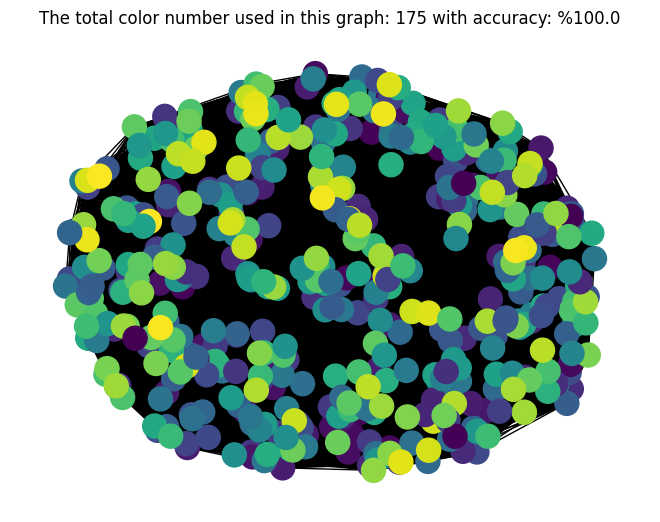

1000 249826



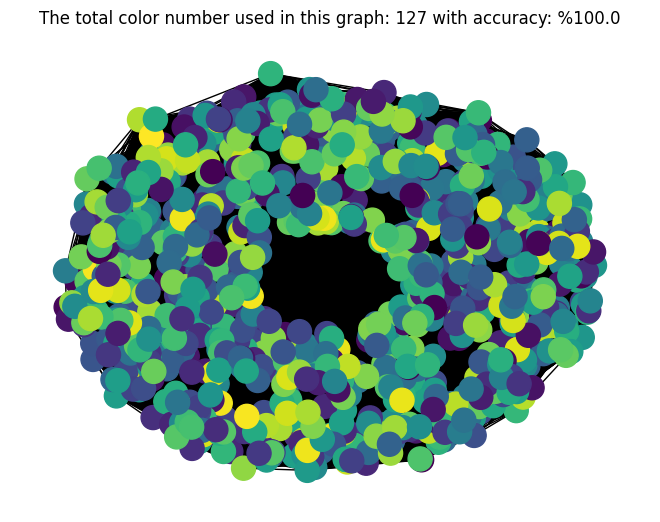

250 15668



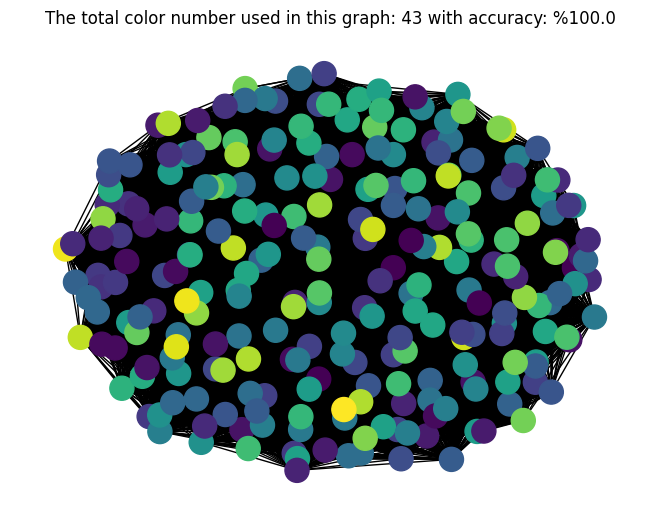

In [16]:
plot_graphs(greedy_results)

#### Step 3
<br>
<li> The Tabu Search Algorithm </li>

In [17]:
tabu_size = 10
tabu_reps = 50

In [18]:
def tabu_coloring(adjacency_list, number_of_colors, previous_solution, is_first_solution):
	"""
    A function to solve the graph coloring problem using tabu search
    """ 
	
	print("Number of Colors:", number_of_colors)
            
    # create a list of available colors
	colors = list(range(number_of_colors))
	iterations = 0
    
    # create a tabu list and an aspiration dictionary
	tabu_list = deque()
	aspiration_dict = {}
    # create a copy of the previous solution
	solution = deepcopy(previous_solution)
    
    # if it's not the first solution, assign a random color to all vertices with color greater than the number of colors
	if not is_first_solution:
		for i in range(len(adjacency_list)):
			if solution[i] >= number_of_colors:
				solution[i] = colors[random.randrange(0, len(colors))]

	while iterations < max_iterations:
		candidates = set()
		conflict_count = 0
        
        # check for conflicting edges and add the vertices to the candidates set
		for vertice, edges in adjacency_list.items():
			for edge in edges:
				if solution[vertice] == solution[edge]:
					candidates.add(vertice)
					candidates.add(edge)
					conflict_count += 1

		candidates = list(candidates)
        # if no conflicts are found, the solution is valid
		if conflict_count == 0:
			break

		new_solution = None
		for _ in range(tabu_reps):
            # choose a random vertex from the candidates
			vertice = candidates[random.randrange(0, len(candidates))]
			new_color = colors[random.randrange(0, len(colors))]
            
            # if the new color is the same as the current color, choose the last color in the list
			if solution[vertice] == new_color:
				new_color = colors[-1]

			new_solution = deepcopy(solution)
			new_solution[vertice] = new_color
			new_conflicts = 0
        
            # check for conflicts in the new solution
			for vertice, edges in adjacency_list.items():
				for edge in edges:
					if vertice is not None and edge is not None and new_solution[vertice] == new_solution[edge]:
						new_conflicts += 1
 
			# if the new solution has less conflicts than the current solution, or the vertex-color combination is in the aspiration dictionary
			if new_conflicts < conflict_count:
				if new_conflicts <= aspiration_dict.setdefault(conflict_count, conflict_count - 1):
					aspiration_dict[conflict_count] = new_conflicts - 1
					if (vertice, new_color) in tabu_list:
						tabu_list.remove((vertice, new_color))
						break
				else:
					if (vertice, new_color) in tabu_list:
						continue
				break

		tabu_list.append((vertice, solution[vertice]))
		if len(tabu_list) > tabu_size:
			tabu_list.popleft()

		solution = deepcopy(new_solution)
		iterations += 1

	if conflict_count != 0:
		return False, previous_solution
	else:
		return True, solution


In [19]:
def tabu_search(adjacency_list, greedy_result_dict, greedy_result_number):
	first_coloring = True
	result = greedy_result_dict
	for v in range(greedy_result_number, 1, -1):
		status, result = tabu_coloring(adjacency_list, v, result, first_coloring)
		if not status:
			break
		first_coloring = False
	
	return result, len(set(result.values()))

#### Step 4
<br>
<li> Run Tabu Search Algorithm with different tabu search algorithm parameters </li>

In [20]:
tabu_results = {}

# for fileName in tqdm.tqdm(fileNames):
#     print("Processing Tabu Search for file:",fileName)
rows = []
for fileName in fileNames:
    print("Tabu Search for file:",fileName)
    start = time.time()
    tabu_results[fileName] = tabu_search(fileName_adj_list[fileName], greedy_results[fileName][0], greedy_results[fileName][1])
    end = time.time()
    
    # new_row = pd.Series({'fileName':str(fileName), 'algorithm':'TabuSearch', 'elapsedTime': (end - start)})
    # df_time_table = append_row(df_time_table, new_row)
    
    rows.append({'fileName': fileName, 'algorithm': 'TabuSearch', 'elapsedTime': end-start})
    
df_time_table = pd.DataFrame(rows)

Tabu Search for file: dsjc500.9
Number of Colors: 175
Number of Colors: 174


Number of Colors: 173


Number of Colors: 172


Number of Colors: 171


Number of Colors: 170


Number of Colors: 169


Number of Colors: 168


Number of Colors: 167


Number of Colors: 166


Number of Colors: 165


Number of Colors: 164


Number of Colors: 163


Tabu Search for file: dsjc1000.5
Number of Colors: 127
Number of Colors: 126


Number of Colors: 125


Number of Colors: 124


Tabu Search for file: dsjc250.5
Number of Colors: 43
Number of Colors: 42
Number of Colors: 41


Number of Colors: 40


Number of Colors: 39


Number of Colors: 38


Number of Colors: 37


Number of Colors: 36


Number of Colors: 35


Number of Colors: 34


Number of Colors: 33


#### Step 5
<br>
<li> Print Tabu Search Results </li>

500 112437



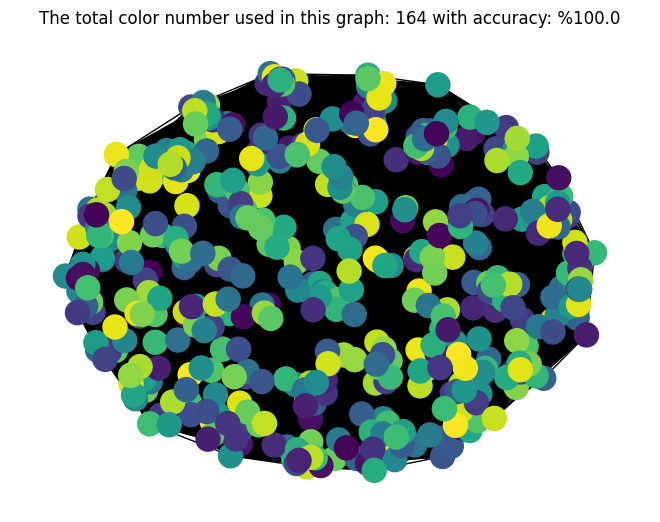

1000 249826



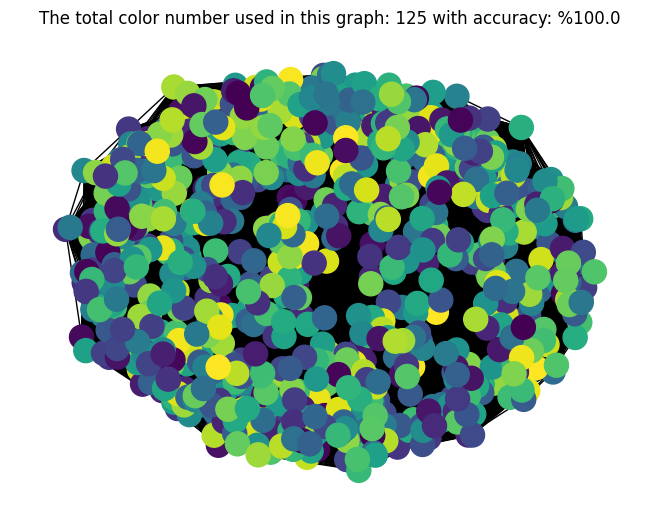

250 15668



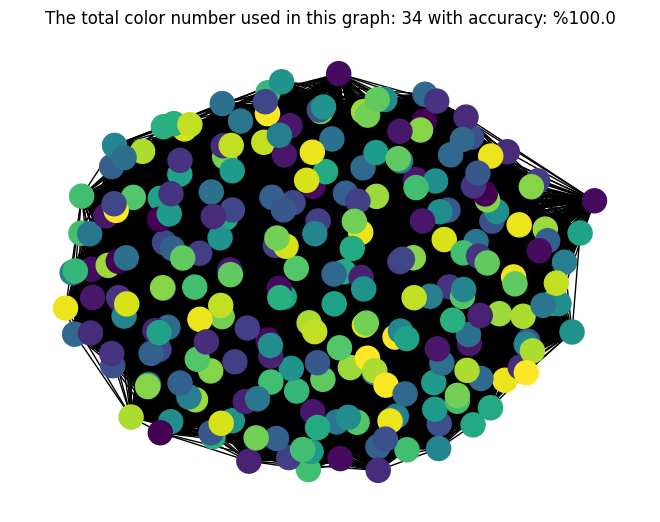

In [21]:
plot_graphs(tabu_results)

### 🏁 End Point

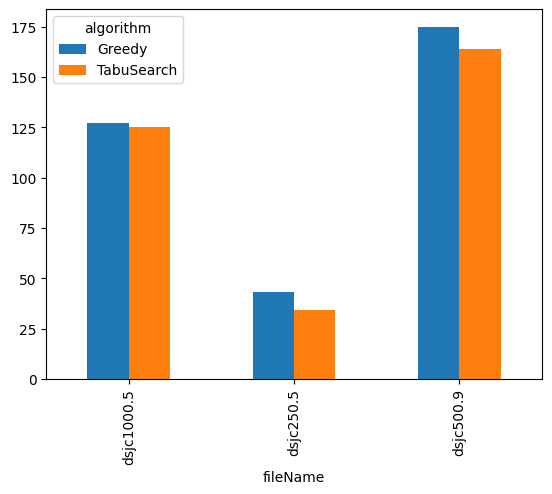

In [22]:
plot_results()

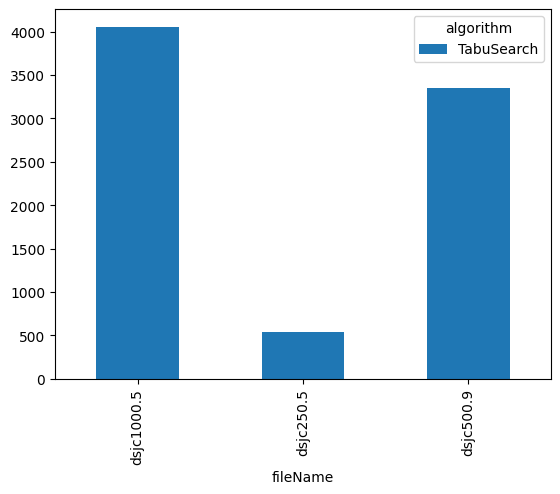

In [23]:
plot_time_table(df_time_table)

In [24]:
display(df_time_table)

,fileName,algorithm,elapsedTime
0,dsjc500.9,TabuSearch,3346.412133
1,dsjc1000.5,TabuSearch,4055.861432
2,dsjc250.5,TabuSearch,534.208873
